In [40]:
import sys
sys.path.insert(0, '../seer/pytorch-hed-master/')
import os
import numpy as np
import imutils
import cv2
import glob
from PIL import Image, ImageFile

import skimage.io as skio
import matplotlib.pyplot as plt


#To fix img truncation issues|
ImageFile.LOAD_TRUNCATED_IMAGES = True

dataRoot = '../Datasets/codex_dresdensis'

glyphDir = dataRoot+'/glyphs'
blockDir = dataRoot+'/blocks'




glyphlist = glob.glob(glyphDir + "/*.png")
blocklist = glob.glob(blockDir + "/.png")


# dataset = []
# for fname in blocklist:
#     img = Image.open(fname).convert('RGB')
#     dataset.append(img)
    
# N = len(dataset)
# DATASET STATISTICS HERE


## cv2 util

In [41]:

def PIL_to_cv(pil_img):
    np_data = np.array(pil_img)
    cv_img = np_data[:,:,::-1].copy()
    return cv_img


../Datasets/codex_dresdensis/blocks/11_10.png


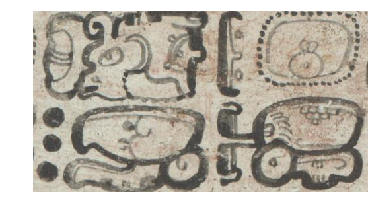

In [42]:

tester = '../Datasets/codex_dresdensis/blocks/11_10.png'
print(tester)
tester_PIL = Image.open(tester).convert('RGB')



%matplotlib inline

plt.figure()
plt.imshow(tester_PIL)
plt.axis("off")
plt.show()


[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.87892807 0.90546227 0.84479314]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.51930827 0.50280124 0.42649248]
  [1.         0.95798326 0.8970807 ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.24531221 0.15266107 0.09533771]
  [0.77617955 0.69537824 0.6356428 ]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]


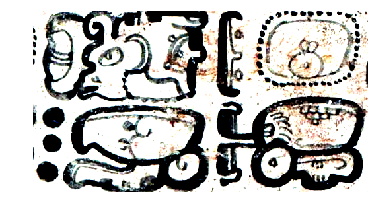

In [43]:
import torch
from torchvision import transforms, datasets

# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[], std=[])
# ])


def preprocess_input_img(inputImage):
    #Norm and mean shift
    inputImage = inputImage.astype(np.float32)
    inputImage = inputImage/255.0
    #inputImage = inputImage[:,:,::-1]
    inputImage -= np.array((0.485, 0.456, 0.406))
    inputImage /= np.array((0.229, 0.224, 0.225))
    inputImage[inputImage >= 1.0] = 1.0
    inputImage[inputImage <= 0.0] = 0.0
    return inputImage

tester_PPd = preprocess_input_img(np.asarray(tester_PIL))
print(tester_PPd)
plt.figure()
plt.imshow(tester_PPd)
plt.axis("off")
plt.show()

Canny Edges
===========

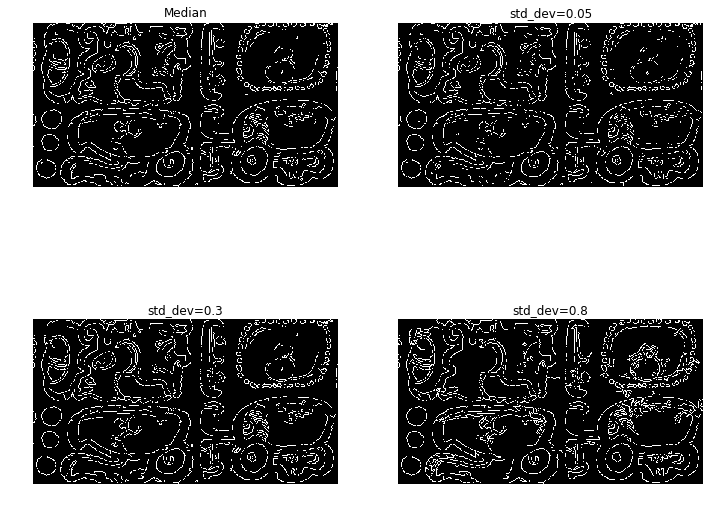

In [44]:

#Get canny edges

def median_canny(source, std_dev=0.25):
    med = np.median(source)
    low_thresh = max(int((1-std_dev) * med), 0)
    high_thresh = max(int((1+std_dev) * med), 0)
    edges = cv2.Canny(source, low_thresh, high_thresh)
    return edges

greyed = cv2.cvtColor(PIL_to_cv(tester_PIL), cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(greyed, (3, 3), 0)

normalized = cv2.normalize(greyed, 1)

none = median_canny(blurred)
tight = median_canny(blurred, std_dev=0.05)
med = median_canny(blurred, std_dev=0.3)
high = median_canny(blurred, std_dev=0.8)


titles=["Median", "std_dev=0.05", "std_dev=0.3", "std_dev=0.8"]
images = [none, tight, med, high]

plt.figure(figsize=(12, 10))

for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(2,2, i+1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
plt.show()

Thresholding & Otsu's Binarization
================

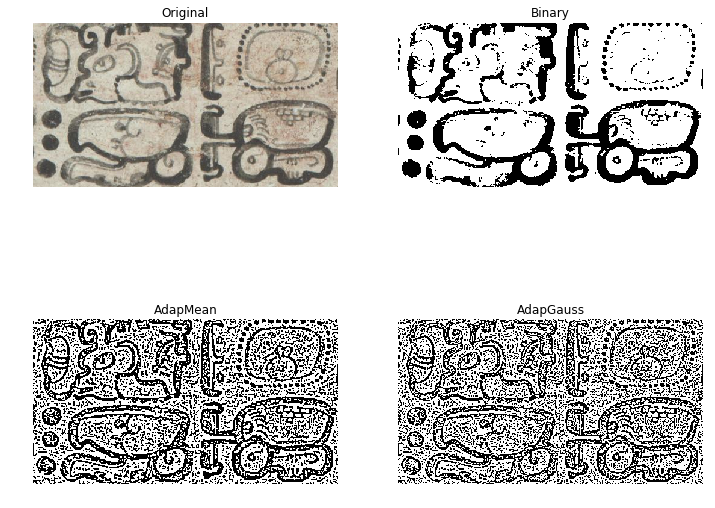

In [45]:


ret,thresh_bin = cv2.threshold(greyed,127,255,cv2.THRESH_BINARY)


thresh_mean = cv2.adaptiveThreshold(greyed,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,7,2)
thresh_gauss = cv2.adaptiveThreshold(greyed,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,7,2)

titles=['Original', 'Binary', 'AdapMean', 'AdapGauss']
images=[tester_PIL, thresh_bin, thresh_mean, thresh_gauss]

plt.figure(figsize=(12, 10))
for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(2, 2, i+1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
plt.show()

Binary Otsu:  [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


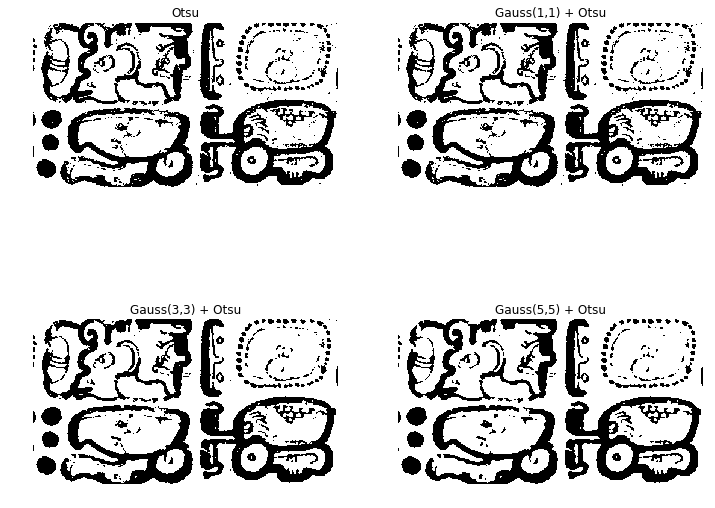

In [46]:
ret, thresh_otsu = cv2.threshold(greyed,0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
gauss_1 = cv2.GaussianBlur(greyed, (1,1), 0)
gauss_3, gauss_5 = cv2.GaussianBlur(greyed, (3,3), 0), cv2.GaussianBlur(greyed, (5,5), 0)

ret_gauss1, thresh_otsu_g1 = cv2.threshold(gauss_1,0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret_gauss3, thresh_otsu_g3 = cv2.threshold(gauss_3,0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret_gauss5, thresh_otsu_g5 = cv2.threshold(gauss_5,0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

titles=[ 'Otsu', 'Gauss(1,1) + Otsu', 'Gauss(3,3) + Otsu', 'Gauss(5,5) + Otsu']
images=[thresh_otsu, thresh_otsu_g1, thresh_otsu_g3, thresh_otsu_g5]

print("Binary Otsu: ", thresh_otsu/255)

def getOtsu(imgFname):
    pil = Image.open(imgFname).convert('RGB')
    greyed = cv2.cvtColor(PIL_to_cv(pil), cv2.COLOR_BGR2GRAY)
    ret, thresh_otsu = cv2.threshold(greyed,0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh_otsu



plt.figure(figsize=(12, 10))
for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(2, 2, i+1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
plt.show()

Superpixel Coloring Segmentation
=======================

In [47]:
from skimage.segmentation import slic
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io, data, color
# import colormaps as cmaps


In [48]:
def segment_color(image, mask):
    (B, G, R) = cv2.split(image.astype("float"))
    R = np.ma.masked_array(R, mask=mask)
    G = np.ma.masked_array(B, mask=mask)
    B = np.ma.masked_array(B, mask=mask)
	# compute the mean and standard deviation of both `rg` and `yb`,
	# then combine them
    R_std = np.sqrt(R.std()**2)
    G_std = np.sqrt(G.std()**2)
    B_std = np.sqrt(B.std()**2)
    R_mean = np.sqrt(R.mean()**2)
    G_mean = np.sqrt(G.mean()**2)
    B_mean = np.sqrt(B.mean()**2)
    
    
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

../Datasets/codex_dresdensis/blocks/11_10.png
clusters = 100 Number of Segments produced :274
clusters = 250 Number of Segments produced :274
clusters = 500 Number of Segments produced :274
clusters = 1000 Number of Segments produced :274
clusters = 1500 Number of Segments produced :274
clusters = 2000 Number of Segments produced :274
clusters = 3000 Number of Segments produced :274


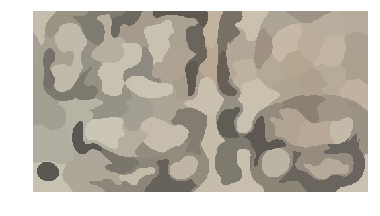

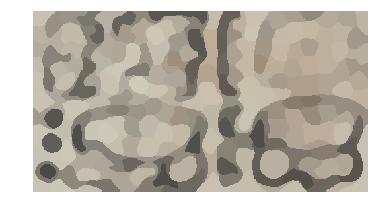

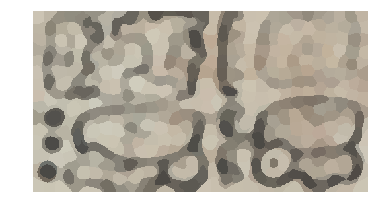

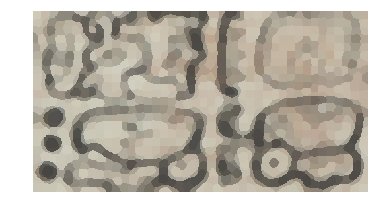

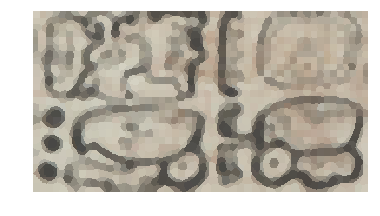

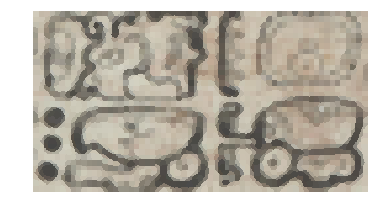

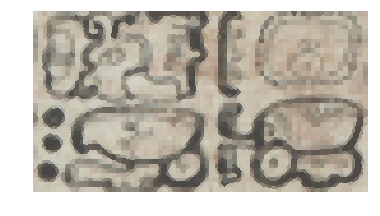

In [49]:
numSegments = [100, 250, 500, 1000, 1500, 2000, 3000]
print(tester)
image = io.imread(tester)
image = img_as_float(image)
white = (255, 255,255)
outline_color = white
cluster_masks = []


colorings = []
for n in numSegments:
    print("clusters = {} ".format(n), end='')
    segs = slic(image, n_segments=n, sigma=5)
    print('Number of Segments produced :{}'.format(len(segs)))
    for superpixel in np.unique(segs):
        mask = np.ones(image.shape[:2])
#         print(mask)
        mask[segs == superpixel] = 0
        cluster_masks.append(mask)
#         C = segment_color(orig, mask)
    coloring = color.label2rgb(segs, image, kind='avg')
    fig= plt.figure('Superpixel: {} cluters'.format(n))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(coloring, cmap='gray')
    colorings.append(coloring)
#     ax.imshow(mark_boundaries(image, segmentation, outline_color))
    plt.axis("off")

plt.show()

In [50]:
# [print(c) for c in colorings]

THRESH: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SKELE: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


(-0.5, 506.5, 273.5, -0.5)

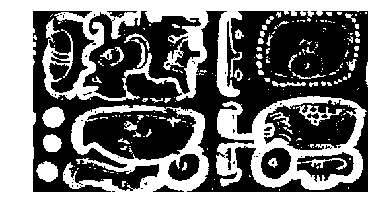

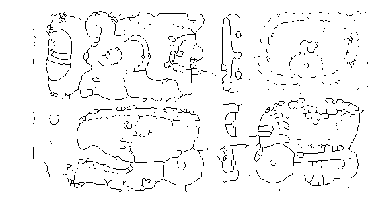

In [51]:
from skimage.morphology import skeletonize, medial_axis
from skimage.util import invert



img = cv2.imread(tester, 0)
kernel = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
blur = cv2.GaussianBlur(opening, (1,1), 0)
ret3, th4 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
th4 = invert(th4, signed_float=False)
th4[th4==255] = 1


print("THRESH:",th4)
skel = skeletonize(th4)
skel = invert(skel)
print("SKELE:", skel)
plt.figure()
plt.imshow(th4, cmap=plt.cm.gray)
plt.axis('off')
plt.figure()
plt.imshow(skel, cmap=plt.cm.gray)
plt.axis('off')


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(-0.5, 506.5, 273.5, -0.5)

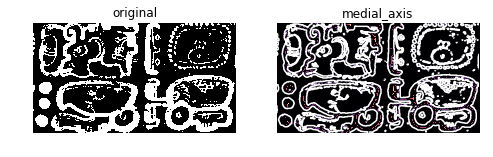

In [52]:
# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(th4, return_distance=True)


# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()
print(th4)
ax[0].imshow(th4, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('original')
ax[0].axis('off')
d = invert(dist_on_skel)
ax[1].imshow(dist_on_skel, cmap='magma', interpolation='nearest')
ax[1].contour(th4, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

No handles with labels found to put in legend.


ls:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 0 1 ... 1 0 0]]


Text(0.5, 1.0, 'Morphological ACWE evolution')

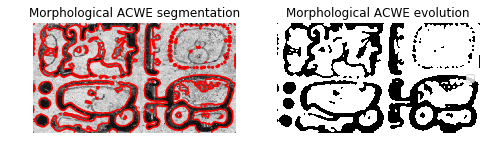

In [53]:

from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
image = img
init_ls = checkerboard_level_set(image.shape, 6)
evolution = []
record = store_evolution_in(evolution)


#Hyper-parameters ITERNUMBER:30 & smoothing:2
ls = morphological_chan_vese(image, 30, init_level_set=init_ls, smoothing=2, iter_callback=record)
print("ls: ", ls)
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()




ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
ax[1].legend(loc="right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)



In [54]:
from model import HED
import torch
import os
import pylab
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [55]:
# from sklearn.metrics import precision_recall_curve


# precision, recall, _ = precision_recall_curve(y_test, y_score)

In [56]:
def grayTrans(img):
    img = img.numpy()[0][0]*255.0
    img = (img).astype(np.uint8)
    return img

In [57]:
def plotResults(images, size):
    pylab.rcParams['figure.figsize'] = size, size
    
    nPlots = len(images)
    titles = ['HED', 'S1', 'S2', 'S3', 'S4']
    plt.figure()
    for i in range(0, len(images)):
        s=plt.subplot(1,nPlots,i+1)
        plt.imshow(images[i], cmap = cm.Greys_r)
        s.set_xticklabels([])
        s.set_yticklabels([])
        s.yaxis.set_ticks_position('none')
        s.xaxis.set_ticks_position('none')
        s.set_title(titles[i],fontsize=35)
    plt.tight_layout()
    plt.show()

In [64]:
from skimage import measure 

def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err
 
def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = measure.compare_ssim(imageA, imageB)
 
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()
    return m, s

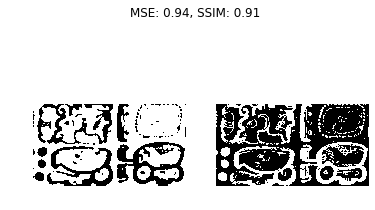

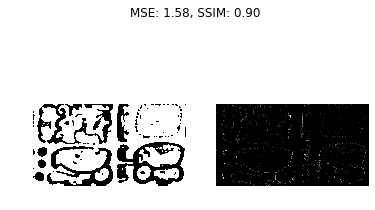

In [59]:
    compare_images(ls, th4, "Base")
    compare_images(ls, dist_on_skel, "Base")

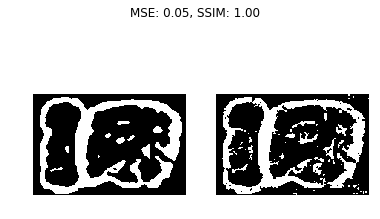

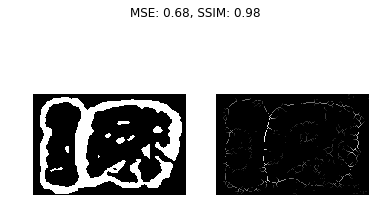

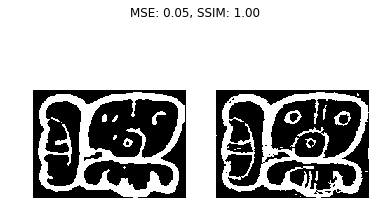

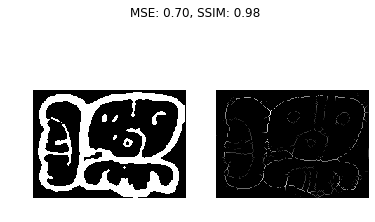

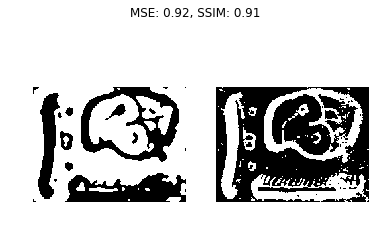

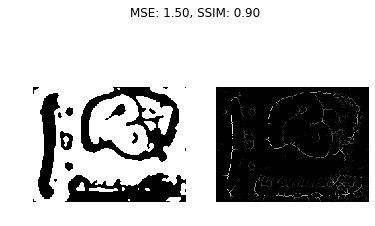

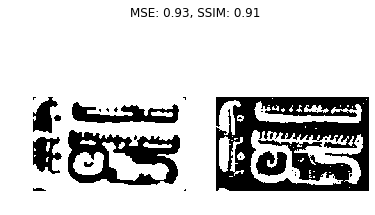

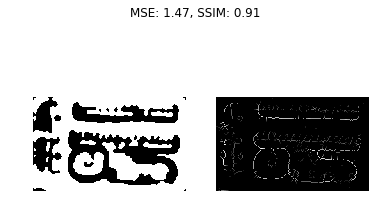

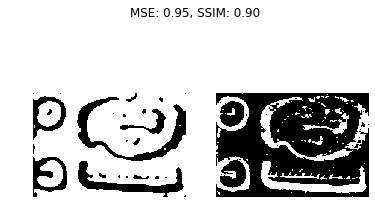

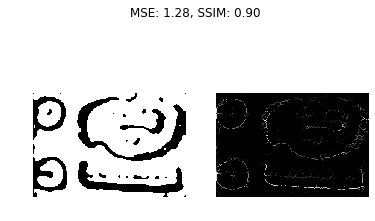

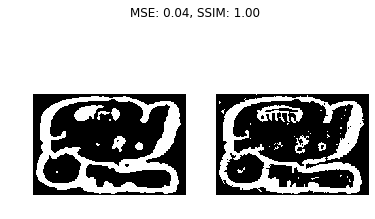

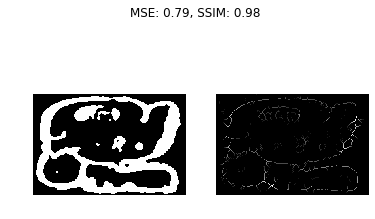

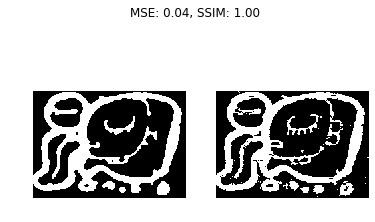

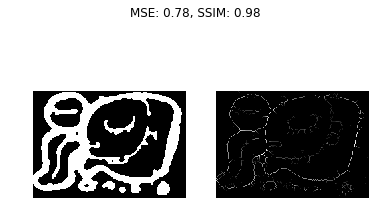

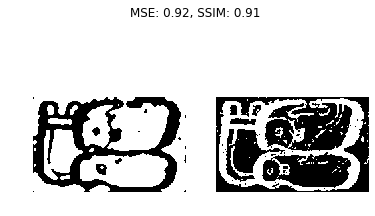

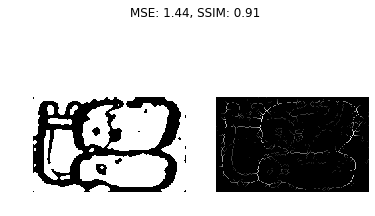

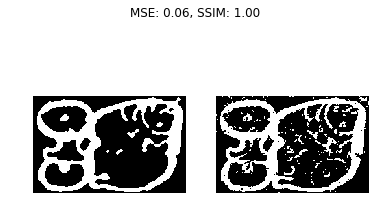

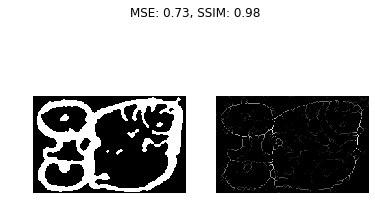

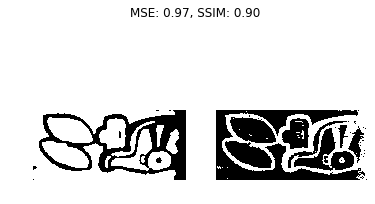

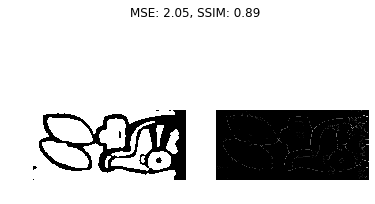

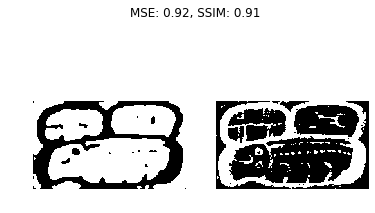

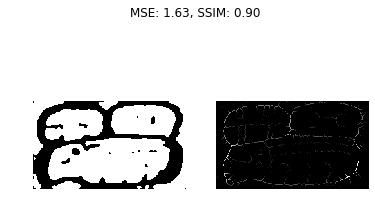

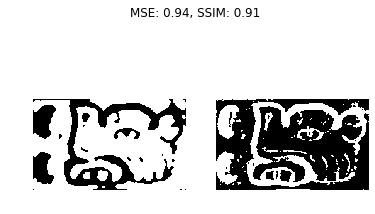

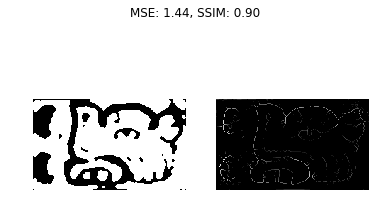

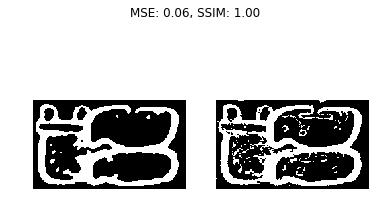

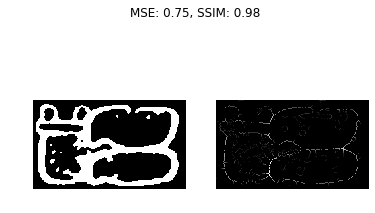

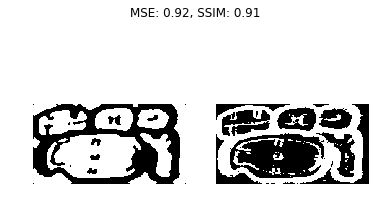

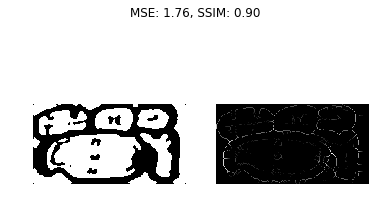

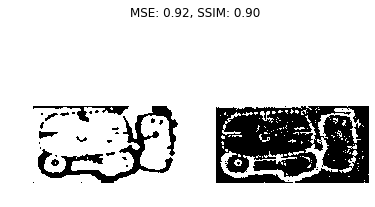

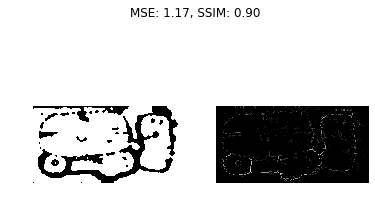

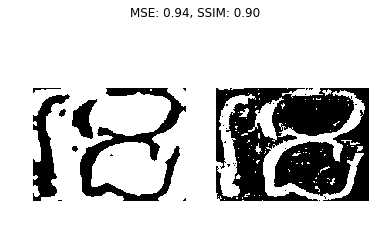

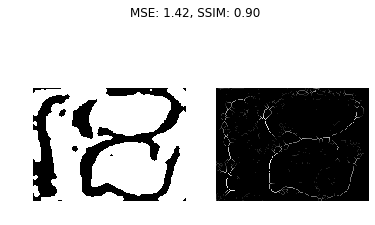

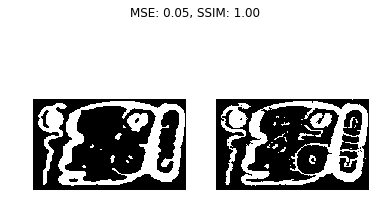

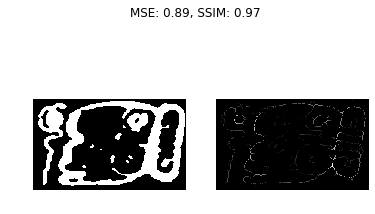

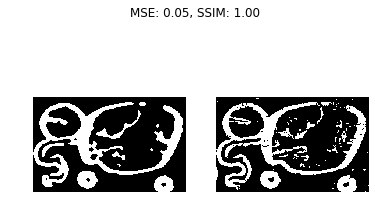

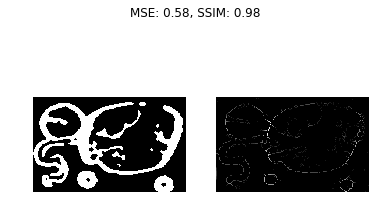

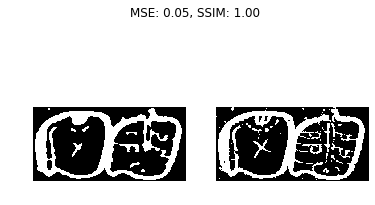

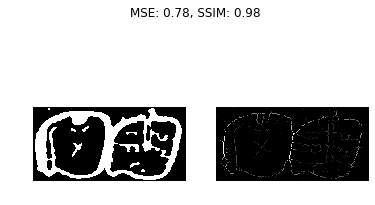

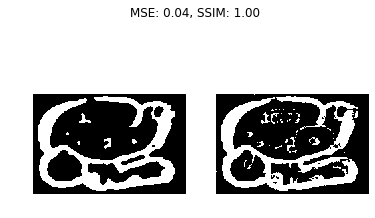

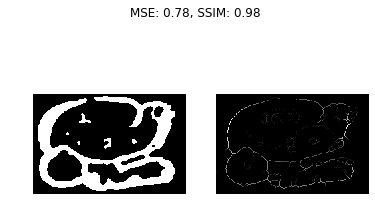

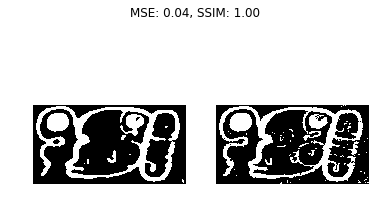

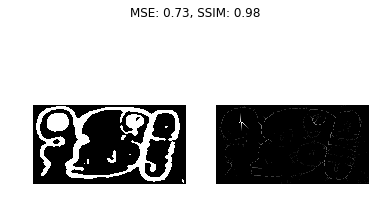

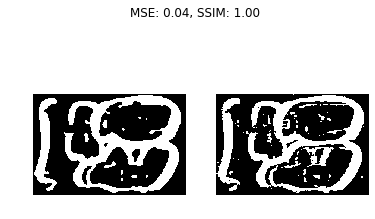

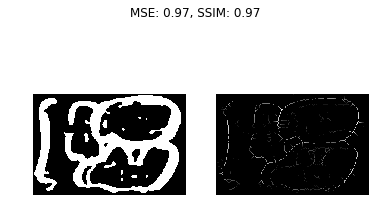

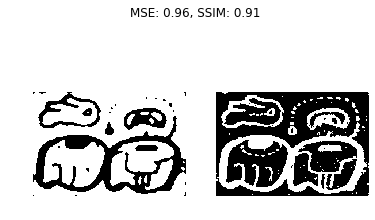

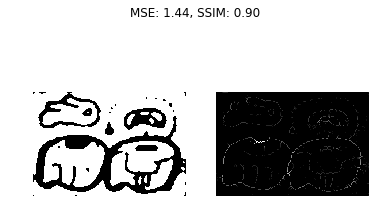

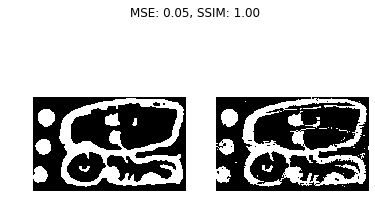

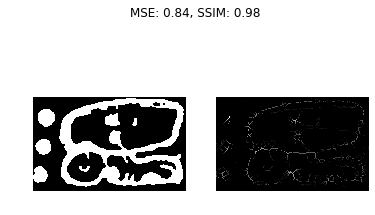

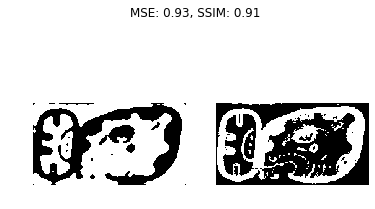

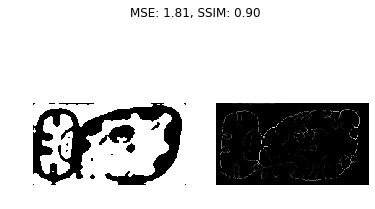

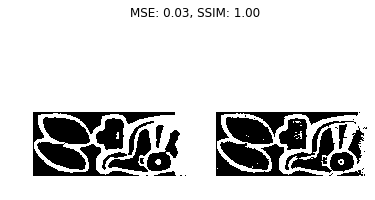

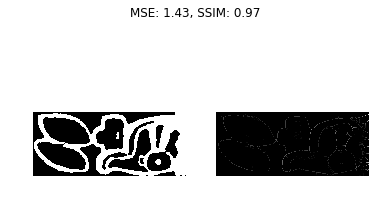

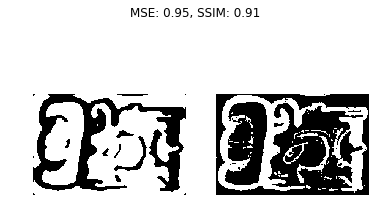

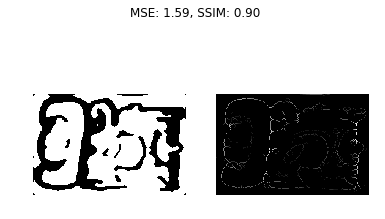

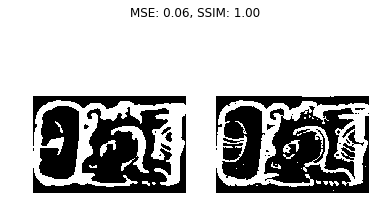

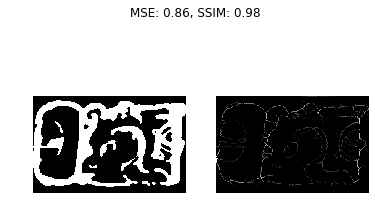

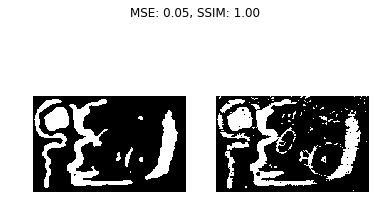

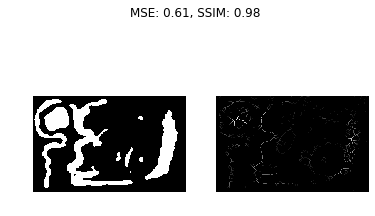

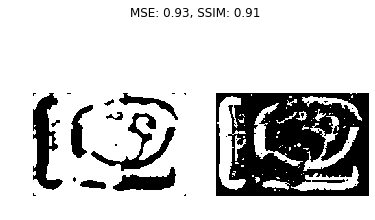

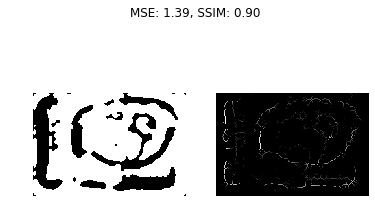

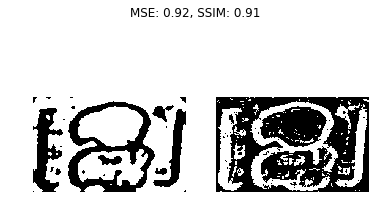

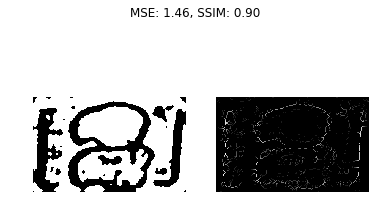

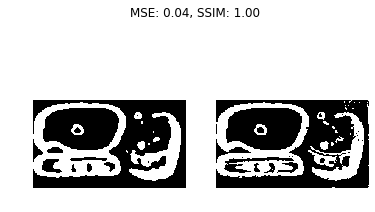

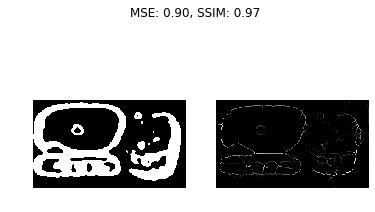

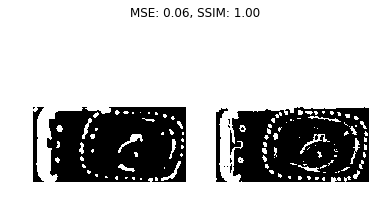

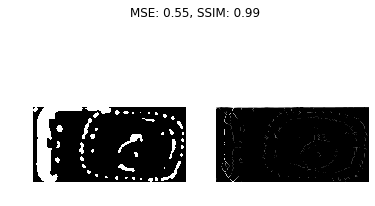

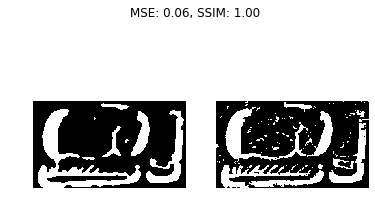

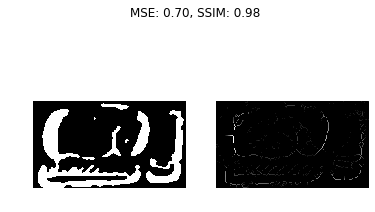

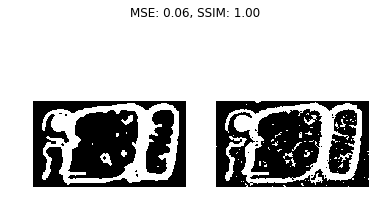

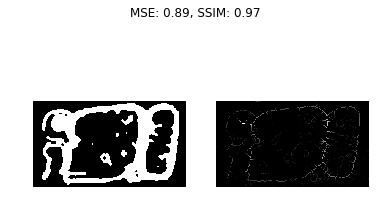

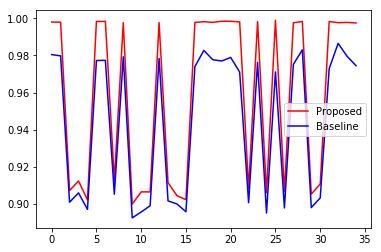

SSIM_Base:  0.9440176860529446
SSIM_Prob:  0.9589253506049159
MSE_Base:  1.1082635918564434
MSE_Prob:  0.4281561539557378


In [77]:
mean_squared_err = []
ssim = []
for g in glyphlist[:35]:
    #Thresholding Ground Truth
    img = cv2.imread(g, 0)
    kernel = np.ones((1,1),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    blur = cv2.GaussianBlur(opening, (1,1), 0)
    ret3, th4 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th4 = invert(th4, signed_float=False)
    th4[th4==255] = 1
    
    #Morphological Proposed
    image = img
    init_ls = checkerboard_level_set(image.shape, 6)
    evolution = []
    record = store_evolution_in(evolution)
    #Hyper-parameters ITERNUMBER:30 & smoothing:2
    ls = morphological_chan_vese(image, 30, init_level_set=init_ls, smoothing=2, iter_callback=record)
    
    
    #Ground Truth Comparison with derived Skeleton example
    # Compute the medial axis (skeleton) and the distance transform
    skel, distance = medial_axis(th4, return_distance=True)
    # Distance to the background for pixels of the skeleton
    dist_on_skel = distance * skel

    
    m1, s1 = compare_images(ls, th4, "Proposed")
    
    m2, s2 = compare_images(ls, dist_on_skel, "Base")
    mean_squared_err.append((m1,m2))
    ssim.append((s1,s2))
    
mse_baseline = [x[1] for x in mean_squared_err]
mse_proposed = [x[0] for x in mean_squared_err]
                           
ssim_baseline = [x[1] for x in ssim]
ssim_proposed = [x[0] for x in ssim]
plt.plot(np.arange(len(ssim)), ssim_proposed, 'r', label='Proposed')
plt.plot(np.arange(len(ssim)), ssim_baseline, 'b', label='Baseline')
plt.legend()
plt.show()
    
    
print("SSIM_Base: ", np.mean(ssim_baseline))
print("SSIM_Prob: ", np.mean(ssim_proposed))
print("MSE_Base: ", np.mean(mse_baseline))
print("MSE_Prob: ", np.mean(mse_proposed))

In [ ]:


def MayaNet():
    
    seerPath = '../seer/pytorch-hed-master/'
    modelPath =  seerPath + 'train/GLYPHDepoch14.pth'
    device = torch.cuda.current_device()
    print(device)
    MayaNet = HED()
  
    MayaNet.cuda(device)
    state = torch.load(modelPath)
    MayaNet.load_state_dict(state['state_dict'])
    return MayaNet

device = torch.cuda.current_device()
print(device)

scribe = MayaNet()

fnames = [tester]

In [ ]:
glyphMask = []

for f in fnames:
    load = torch.FloatTensor(np.array(Image.open(f))[:, :, ::-1].transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0))
    w, h = load.size(2), load.size(1)
    new = load.cuda(device).view(1,3, h, w)
    inp = Variable(new)
#     print(inp)
#     print(inp.size())
    # perform forward computation
    s1,s2,s3,s4,s5,s6 = scribe.forward(inp)

    # convert back to numpy arrays
    out = []
    out.append(grayTrans(s6.data.cpu()))
    out.append(grayTrans(s1.data.cpu()))
    out.append(grayTrans(s2.data.cpu()))
    out.append(grayTrans(s3.data.cpu()))
    out.append(grayTrans(s4.data.cpu()))

    fuse = Image.fromarray(out[0], 'L')
    mask = np.copy(out[1])
    mask[mask>73] = 1
    print(mask)
    plt.imshow(mask)
    glyphMask.append(mask)
    # visualize every 10th image
    plotResults(out, 25)